In [5]:
!pip install gym
!pip install numpy
import gym
from gym import spaces
import numpy as np

class Dust2LiteEnv(gym.Env):
    """CSGO Dust2 abstracted environment"""
    def __init__(self):
        super().__init__()
        # 空间定义
        self.map_size = 100
        self.goal_area = np.array([80, 80])
        self.num_enemies = 5
        
        # 状态空间: [x, y, health, ammo, goal_dist, enemy_dist, enemy_angle, time_alive]
        self.observation_space = spaces.Box(low=0, high=1, shape=(8,), dtype=np.float32)
        
        # 动作: 前后转向 射击 装弹
        self.action_space = spaces.Discrete(6)
        
        self.reset()
    
    def reset(self):
        self.agent_pos = np.array([10.0, 10.0])
        self.agent_angle = 0.0
        self.health = 1.0
        self.ammo = 1.0
        self.time_alive = 0.0
        
        # 敌人随机分布
        self.enemies = np.random.uniform(0, self.map_size, size=(self.num_enemies, 2))
        self.enemy_alive = np.ones(self.num_enemies, dtype=bool)
        
        return self._get_obs()
    
    def _get_obs(self):
        # 最近敌人距离与角度
        alive_enemies = self.enemies[self.enemy_alive]
        if len(alive_enemies) > 0:
            dists = np.linalg.norm(alive_enemies - self.agent_pos, axis=1)
            nearest_enemy = alive_enemies[np.argmin(dists)]
            enemy_dist = np.clip(np.min(dists) / self.map_size, 0, 1)
            rel_vec = nearest_enemy - self.agent_pos
            enemy_angle = np.arctan2(rel_vec[1], rel_vec[0]) / np.pi
        else:
            enemy_dist, enemy_angle = 1.0, 0.0
        
        goal_dist = np.linalg.norm(self.goal_area - self.agent_pos) / self.map_size
        obs = np.array([
            self.agent_pos[0] / self.map_size,
            self.agent_pos[1] / self.map_size,
            self.health,
            self.ammo,
            goal_dist,
            enemy_dist,
            enemy_angle,
            self.time_alive / 1000
        ], dtype=np.float32)
        return obs
    
    def step(self, action):
        reward, done = 0.0, False
        
        # 基本移动
        if action == 0:  # forward
            self.agent_pos += 2 * np.array([np.cos(self.agent_angle), np.sin(self.agent_angle)])
        elif action == 1:  # backward
            self.agent_pos -= 2 * np.array([np.cos(self.agent_angle), np.sin(self.agent_angle)])
        elif action == 2:  # turn left
            self.agent_angle -= 0.2
        elif action == 3:  # turn right
            self.agent_angle += 0.2
        elif action == 4:  # shoot
            if self.ammo > 0:
                reward += self._try_shoot()
                self.ammo -= 0.1
            else:
                reward -= 0.5
        elif action == 5:  # reload
            self.ammo = 1.0
            reward -= 0.2
        
        # 存活奖励
        self.time_alive += 1
        reward += 0.1
        
        # 距离目标奖励
        goal_dist = np.linalg.norm(self.goal_area - self.agent_pos)
        if goal_dist < 5:
            reward += 20
            done = True
        else:
            reward += 0.05 * (1 - goal_dist / self.map_size)
        
        # 生命衰减与敌人攻击模拟
        self.health -= np.random.rand() * 0.02
        if self.health <= 0:
            reward -= 20
            done = True
        
        obs = self._get_obs()
        self.agent_pos = np.clip(self.agent_pos, 0, self.map_size)

        return obs, reward, done, {}
    
    def _try_shoot(self):
        """射击命中概率与距离相关"""
        hit_reward = 0
        for i, pos in enumerate(self.enemies):
            if not self.enemy_alive[i]:
                continue
            dist = np.linalg.norm(pos - self.agent_pos)
            if dist < 15 and np.random.rand() < 0.6:  # 命中概率
                self.enemy_alive[i] = False
                hit_reward += 10
        return hit_reward


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [11]:
!pip install matplotlib
import matplotlib.pyplot as plt

class Dust2Visualizer:
    def __init__(self, env):
        self.env = env
        self.fig, self.ax = plt.subplots(figsize=(5, 5))
        plt.ion()
        self.ax.set_xlim(0, env.map_size)
        self.ax.set_ylim(0, env.map_size)
        self.agent_plot, = self.ax.plot([], [], 'bo', markersize=8, label='Agent')
        self.enemy_plot, = self.ax.plot([], [], 'rx', markersize=6, label='Enemies')
        self.goal_plot, = self.ax.plot([], [], 'gs', markersize=10, label='Goal')
        self.ax.legend()

    def update(self):
        self.ax.clear()
        self.ax.set_xlim(0, self.env.map_size)
        self.ax.set_ylim(0, self.env.map_size)
        self.ax.set_title("Dust2 Lite Visualization")

        # 画目标区
        self.ax.plot(self.env.goal_area[0], self.env.goal_area[1], 'gs', markersize=10, label='Goal')

        # 画存活的敌人
        alive = self.env.enemies[self.env.enemy_alive]
        if len(alive) > 0:
            self.ax.scatter(alive[:, 0], alive[:, 1], c='r', marker='x', label='Enemy')

        # 画 agent
        self.ax.plot(self.env.agent_pos[0], self.env.agent_pos[1], 'bo', markersize=8, label='Agent')

        # 画朝向
        direction = np.array([np.cos(self.env.agent_angle), np.sin(self.env.agent_angle)]) * 5
        self.ax.arrow(self.env.agent_pos[0], self.env.agent_pos[1], direction[0], direction[1],
                      head_width=1.5, color='blue')

        # 画血量、弹药
        self.ax.text(2, 95, f"Health: {self.env.health:.2f}", color='red')
        self.ax.text(2, 90, f"Ammo: {self.env.ammo:.2f}", color='green')
        self.ax.text(2, 85, f"Alive time: {self.env.time_alive:.0f}", color='black')

        plt.pause(0.05)


Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp39-cp39-macosx_10_9_universal2.whl.metadata (112 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 3.4 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 2.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 1.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


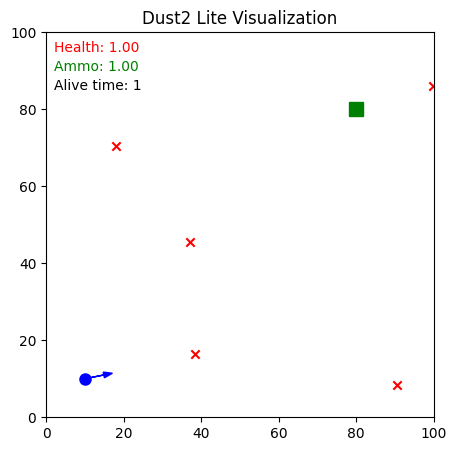

Total Reward: -13.342072983564742


In [17]:
env = Dust2LiteEnv()
viz = Dust2Visualizer(env)

obs = env.reset()
done = False
total_reward = 0

while not done:
    action = env.action_space.sample()
    obs, r, done, _ = env.step(action)
    total_reward += r
    viz.update()

print("Total Reward:", total_reward)
plt.ioff()
plt.show()


In [14]:
!pip install torch numpy matplotlib tqdm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


  2%|▏         | 23/1000 [00:00<00:39, 24.57it/s]

Episode 20, avg reward = 2.69, EPS_META=1.00, EPS_LOW=1.00
Episode 20, avg reward = 2.69, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 3}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 3}
tensor([-0.0599, -0.0508, -0.0087], grad_fn=<ViewBackward0>)


  4%|▍         | 41/1000 [00:02<01:05, 14.60it/s]

Episode 40, avg reward = 3.56, EPS_META=1.00, EPS_LOW=1.00
Episode 40, avg reward = 3.56, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 2, 'ENGAGE': 2, 'RELOAD': 0}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 2, 'ENGAGE': 2, 'RELOAD': 0}
tensor([ 0.0955, -7.2233,  0.2245], grad_fn=<ViewBackward0>)


  5%|▌         | 51/1000 [00:02<01:10, 13.37it/s]

[MetaPick] goals=['GO_TO_GOAL', 'ENGAGE', 'RELOAD'], mask=[ True  True False], pick=GO_TO_GOAL, q=[  5.080454  -28.622786    4.5818343]


  6%|▌         | 61/1000 [00:03<01:08, 13.64it/s]

Episode 60, avg reward = 2.19, EPS_META=1.00, EPS_LOW=1.00
Episode 60, avg reward = 2.19, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 2, 'ENGAGE': 2, 'RELOAD': 0}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 2, 'ENGAGE': 2, 'RELOAD': 0}
tensor([-1.3391, -4.2001, -1.1362], grad_fn=<ViewBackward0>)


  8%|▊         | 81/1000 [00:05<01:06, 13.75it/s]

Episode 80, avg reward = 3.79, EPS_META=1.00, EPS_LOW=1.00
Episode 80, avg reward = 3.79, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 3, 'ENGAGE': 1, 'RELOAD': 0}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 3, 'ENGAGE': 1, 'RELOAD': 0}
tensor([-0.9563, -2.1767, -1.1927], grad_fn=<ViewBackward0>)


 10%|█         | 101/1000 [00:06<01:02, 14.36it/s]

[MetaPick] goals=['GO_TO_GOAL', 'ENGAGE', 'RELOAD'], mask=[ True  True False], pick=RELOAD, q=[  5.961275  -18.85948     6.3185205]
Episode 100, avg reward = 4.09, EPS_META=1.00, EPS_LOW=1.00
Episode 100, avg reward = 4.09, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 2}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 2}
tensor([-0.9604, -2.9335, -0.9388], grad_fn=<ViewBackward0>)


 12%|█▏        | 121/1000 [00:08<01:02, 14.06it/s]

Episode 120, avg reward = 3.76, EPS_META=1.00, EPS_LOW=1.00
Episode 120, avg reward = 3.76, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 2, 'ENGAGE': 1, 'RELOAD': 2}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 2, 'ENGAGE': 1, 'RELOAD': 2}
tensor([-0.8765, -3.6533, -0.8572], grad_fn=<ViewBackward0>)


 14%|█▍        | 141/1000 [00:09<01:01, 14.07it/s]

Episode 140, avg reward = 3.49, EPS_META=1.00, EPS_LOW=1.00
Episode 140, avg reward = 3.49, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 1}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 1}
tensor([-0.9177, -3.5858, -0.8481], grad_fn=<ViewBackward0>)


 15%|█▌        | 151/1000 [00:10<00:58, 14.43it/s]

[MetaPick] goals=['GO_TO_GOAL', 'ENGAGE', 'RELOAD'], mask=[ True  True False], pick=ENGAGE, q=[  4.0106325 -22.772745    4.205689 ]


 16%|█▌        | 161/1000 [00:10<00:59, 14.06it/s]

Episode 160, avg reward = 3.41, EPS_META=1.00, EPS_LOW=1.00
Episode 160, avg reward = 3.41, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 1, 'ENGAGE': 3, 'RELOAD': 0}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 1, 'ENGAGE': 3, 'RELOAD': 0}
tensor([-0.9755, -3.1411, -0.8718], grad_fn=<ViewBackward0>)


 18%|█▊        | 181/1000 [00:12<00:57, 14.13it/s]

Episode 180, avg reward = 2.85, EPS_META=1.00, EPS_LOW=1.00
Episode 180, avg reward = 2.85, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 2, 'ENGAGE': 2, 'RELOAD': 0}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 2, 'ENGAGE': 2, 'RELOAD': 0}
tensor([-1.0739, -3.1792, -0.9338], grad_fn=<ViewBackward0>)


 20%|██        | 201/1000 [00:13<00:54, 14.65it/s]

[MetaPick] goals=['GO_TO_GOAL', 'ENGAGE', 'RELOAD'], mask=[ True  True False], pick=ENGAGE, q=[  0.58662593 -30.416521     0.53991896]
[Exploration pulse] EPS_META -> 1.00
Episode 200, avg reward = 2.70, EPS_META=1.00, EPS_LOW=1.00
Episode 200, avg reward = 2.70, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 2, 'ENGAGE': 1, 'RELOAD': 1}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 2, 'ENGAGE': 1, 'RELOAD': 1}
tensor([-1.1335, -2.3978, -1.0652], grad_fn=<ViewBackward0>)


 22%|██▏       | 221/1000 [00:15<00:58, 13.27it/s]

Episode 220, avg reward = 2.54, EPS_META=1.00, EPS_LOW=1.00
Episode 220, avg reward = 2.54, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 2, 'ENGAGE': 2, 'RELOAD': 0}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 2, 'ENGAGE': 2, 'RELOAD': 0}
tensor([-1.1718, -1.7098, -1.0983], grad_fn=<ViewBackward0>)


 24%|██▍       | 241/1000 [00:16<00:57, 13.13it/s]

Episode 240, avg reward = 3.66, EPS_META=1.00, EPS_LOW=1.00
Episode 240, avg reward = 3.66, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 3, 'ENGAGE': 0, 'RELOAD': 1}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 3, 'ENGAGE': 0, 'RELOAD': 1}
tensor([-1.2527, -1.5644, -1.1303], grad_fn=<ViewBackward0>)


 25%|██▌       | 251/1000 [00:17<00:58, 12.78it/s]

[MetaPick] goals=['GO_TO_GOAL', 'ENGAGE', 'RELOAD'], mask=[ True  True False], pick=GO_TO_GOAL, q=[  3.529417 -23.821312   3.466496]


 26%|██▌       | 261/1000 [00:18<00:57, 12.75it/s]

Episode 260, avg reward = 4.65, EPS_META=1.00, EPS_LOW=1.00
Episode 260, avg reward = 4.65, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 2, 'ENGAGE': 1, 'RELOAD': 2}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 2, 'ENGAGE': 1, 'RELOAD': 2}
tensor([-1.3262, -1.6297, -1.2359], grad_fn=<ViewBackward0>)


 28%|██▊       | 281/1000 [00:19<00:51, 13.88it/s]

Episode 280, avg reward = 3.37, EPS_META=1.00, EPS_LOW=1.00
Episode 280, avg reward = 3.37, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 2}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 2}
tensor([-1.2780, -1.0142, -1.2054], grad_fn=<ViewBackward0>)


 30%|███       | 301/1000 [00:21<00:49, 14.05it/s]

[MetaPick] goals=['GO_TO_GOAL', 'ENGAGE', 'RELOAD'], mask=[ True  True False], pick=ENGAGE, q=[  2.5125866 -27.650814    2.5677269]
Episode 300, avg reward = 3.38, EPS_META=1.00, EPS_LOW=1.00
Episode 300, avg reward = 3.38, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 0, 'ENGAGE': 3, 'RELOAD': 3}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 0, 'ENGAGE': 3, 'RELOAD': 3}
tensor([-1.2276, -0.9662, -1.1678], grad_fn=<ViewBackward0>)


 32%|███▏      | 321/1000 [00:22<00:48, 13.95it/s]

Episode 320, avg reward = 3.76, EPS_META=1.00, EPS_LOW=1.00
Episode 320, avg reward = 3.76, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 3, 'ENGAGE': 0, 'RELOAD': 2}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 3, 'ENGAGE': 0, 'RELOAD': 2}
tensor([-1.1949, -1.1272, -1.1665], grad_fn=<ViewBackward0>)


 34%|███▍      | 341/1000 [00:24<00:48, 13.50it/s]

Episode 340, avg reward = 3.01, EPS_META=1.00, EPS_LOW=1.00
Episode 340, avg reward = 3.01, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 2, 'ENGAGE': 2, 'RELOAD': 1}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 2, 'ENGAGE': 2, 'RELOAD': 1}
tensor([-1.2509, -1.2754, -1.2091], grad_fn=<ViewBackward0>)


 35%|███▌      | 351/1000 [00:24<00:47, 13.63it/s]

[MetaPick] goals=['GO_TO_GOAL', 'ENGAGE', 'RELOAD'], mask=[ True  True False], pick=GO_TO_GOAL, q=[  1.7667826 -28.072756    1.5306058]


 36%|███▌      | 361/1000 [00:25<00:45, 14.03it/s]

Episode 360, avg reward = 3.10, EPS_META=1.00, EPS_LOW=1.00
Episode 360, avg reward = 3.10, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 1}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 1}
tensor([-1.1090, -1.1213, -1.1423], grad_fn=<ViewBackward0>)


 38%|███▊      | 381/1000 [00:27<00:46, 13.18it/s]

Episode 380, avg reward = 4.42, EPS_META=1.00, EPS_LOW=1.00
Episode 380, avg reward = 4.42, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 1}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 1}
tensor([-1.0645, -0.9214, -1.0811], grad_fn=<ViewBackward0>)


 40%|████      | 401/1000 [00:28<00:45, 13.09it/s]

[MetaPick] goals=['GO_TO_GOAL', 'ENGAGE', 'RELOAD'], mask=[ True  True False], pick=GO_TO_GOAL, q=[  2.1049361 -27.794085    1.9604628]
[Exploration pulse] EPS_META -> 1.00
Episode 400, avg reward = 3.17, EPS_META=1.00, EPS_LOW=1.00
Episode 400, avg reward = 3.17, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 3, 'ENGAGE': 1, 'RELOAD': 1}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 3, 'ENGAGE': 1, 'RELOAD': 1}
tensor([-1.0651, -1.2402, -1.0461], grad_fn=<ViewBackward0>)


 42%|████▏     | 421/1000 [00:30<00:43, 13.33it/s]

Episode 420, avg reward = 3.52, EPS_META=1.00, EPS_LOW=1.00
Episode 420, avg reward = 3.52, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 3, 'ENGAGE': 0, 'RELOAD': 1}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 3, 'ENGAGE': 0, 'RELOAD': 1}
tensor([-0.9697, -1.6660, -1.0000], grad_fn=<ViewBackward0>)


 44%|████▍     | 441/1000 [00:31<00:40, 13.92it/s]

Episode 440, avg reward = 4.58, EPS_META=1.00, EPS_LOW=1.00
Episode 440, avg reward = 4.58, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 2, 'ENGAGE': 1, 'RELOAD': 1}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 2, 'ENGAGE': 1, 'RELOAD': 1}
tensor([-0.9487, -1.5866, -0.9757], grad_fn=<ViewBackward0>)


 45%|████▌     | 451/1000 [00:32<00:40, 13.41it/s]

[MetaPick] goals=['GO_TO_GOAL', 'ENGAGE', 'RELOAD'], mask=[ True  True False], pick=GO_TO_GOAL, q=[  2.94666   -26.532       2.7248602]


 46%|████▌     | 461/1000 [00:33<00:42, 12.81it/s]

Episode 460, avg reward = 2.31, EPS_META=1.00, EPS_LOW=1.00
Episode 460, avg reward = 2.31, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 3, 'ENGAGE': 1, 'RELOAD': 0}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 3, 'ENGAGE': 1, 'RELOAD': 0}
tensor([-1.0684, -1.9192, -1.0211], grad_fn=<ViewBackward0>)


 48%|████▊     | 481/1000 [00:34<00:39, 13.21it/s]

Episode 480, avg reward = 4.04, EPS_META=1.00, EPS_LOW=1.00
Episode 480, avg reward = 4.04, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 2, 'ENGAGE': 1, 'RELOAD': 2}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 2, 'ENGAGE': 1, 'RELOAD': 2}
tensor([-0.9502, -1.7180, -0.9424], grad_fn=<ViewBackward0>)


 50%|█████     | 501/1000 [00:36<00:37, 13.39it/s]

[MetaPick] goals=['GO_TO_GOAL', 'ENGAGE', 'RELOAD'], mask=[ True  True False], pick=GO_TO_GOAL, q=[ 7.779492   -0.72570777  7.5691123 ]
Episode 500, avg reward = 3.19, EPS_META=1.00, EPS_LOW=1.00
Episode 500, avg reward = 3.19, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 2, 'ENGAGE': 2, 'RELOAD': 0}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 2, 'ENGAGE': 2, 'RELOAD': 0}
tensor([-0.9872, -2.0155, -0.9408], grad_fn=<ViewBackward0>)


 52%|█████▏    | 521/1000 [00:37<00:34, 13.89it/s]

Episode 520, avg reward = 4.24, EPS_META=1.00, EPS_LOW=1.00
Episode 520, avg reward = 4.24, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 2, 'ENGAGE': 1, 'RELOAD': 1}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 2, 'ENGAGE': 1, 'RELOAD': 1}
tensor([-1.0077, -1.9057, -0.9052], grad_fn=<ViewBackward0>)


 54%|█████▍    | 541/1000 [00:39<00:36, 12.60it/s]

Episode 540, avg reward = 3.46, EPS_META=1.00, EPS_LOW=1.00
Episode 540, avg reward = 3.46, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 2, 'ENGAGE': 1, 'RELOAD': 3}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 2, 'ENGAGE': 1, 'RELOAD': 3}
tensor([-0.9351, -2.2061, -0.8269], grad_fn=<ViewBackward0>)


 55%|█████▌    | 551/1000 [00:40<00:34, 13.12it/s]

[MetaPick] goals=['GO_TO_GOAL', 'ENGAGE', 'RELOAD'], mask=[ True  True False], pick=RELOAD, q=[  2.048242  -28.297266    2.3703468]


 56%|█████▌    | 561/1000 [00:40<00:31, 13.74it/s]

Episode 560, avg reward = 2.38, EPS_META=1.00, EPS_LOW=1.00
Episode 560, avg reward = 2.38, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 1}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 1}
tensor([-0.9204, -1.8799, -0.8638], grad_fn=<ViewBackward0>)


 58%|█████▊    | 581/1000 [00:42<00:37, 11.32it/s]

Episode 580, avg reward = 2.80, EPS_META=1.00, EPS_LOW=1.00
Episode 580, avg reward = 2.80, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 1, 'ENGAGE': 3, 'RELOAD': 0}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 1, 'ENGAGE': 3, 'RELOAD': 0}
tensor([-0.9020, -1.9416, -0.8546], grad_fn=<ViewBackward0>)


 60%|██████    | 601/1000 [00:43<00:28, 13.91it/s]

[MetaPick] goals=['GO_TO_GOAL', 'ENGAGE', 'RELOAD'], mask=[ True  True False], pick=ENGAGE, q=[  3.4124138 -24.921871    3.4035943]
[Exploration pulse] EPS_META -> 1.00
Episode 600, avg reward = 3.25, EPS_META=1.00, EPS_LOW=1.00
Episode 600, avg reward = 3.25, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 1, 'ENGAGE': 3, 'RELOAD': 3}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 1, 'ENGAGE': 3, 'RELOAD': 3}
tensor([-0.9469, -1.7460, -0.8909], grad_fn=<ViewBackward0>)


 62%|██████▏   | 621/1000 [00:45<00:32, 11.81it/s]

Episode 620, avg reward = 3.87, EPS_META=1.00, EPS_LOW=1.00
Episode 620, avg reward = 3.87, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 2, 'ENGAGE': 1, 'RELOAD': 2}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 2, 'ENGAGE': 1, 'RELOAD': 2}
tensor([-1.0300, -2.0223, -0.9592], grad_fn=<ViewBackward0>)


 64%|██████▍   | 641/1000 [00:47<00:26, 13.65it/s]

Episode 640, avg reward = 3.53, EPS_META=1.00, EPS_LOW=1.00
Episode 640, avg reward = 3.53, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 2, 'ENGAGE': 2, 'RELOAD': 5}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 2, 'ENGAGE': 2, 'RELOAD': 5}
tensor([-1.0461, -2.2963, -0.9671], grad_fn=<ViewBackward0>)


 65%|██████▌   | 651/1000 [00:48<00:26, 13.10it/s]

[MetaPick] goals=['GO_TO_GOAL', 'ENGAGE', 'RELOAD'], mask=[ True  True False], pick=ENGAGE, q=[ 6.942331 -5.829433  7.072512]


 66%|██████▌   | 661/1000 [00:48<00:24, 13.77it/s]

Episode 660, avg reward = 3.29, EPS_META=1.00, EPS_LOW=1.00
Episode 660, avg reward = 3.29, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 2, 'ENGAGE': 1, 'RELOAD': 3}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 2, 'ENGAGE': 1, 'RELOAD': 3}
tensor([-1.0853, -1.8807, -1.0826], grad_fn=<ViewBackward0>)


 68%|██████▊   | 681/1000 [00:50<00:23, 13.68it/s]

Episode 680, avg reward = 3.55, EPS_META=1.00, EPS_LOW=1.00
Episode 680, avg reward = 3.55, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 2}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 2}
tensor([-1.1130, -2.2154, -1.1171], grad_fn=<ViewBackward0>)


 70%|███████   | 701/1000 [00:51<00:22, 13.38it/s]

[MetaPick] goals=['GO_TO_GOAL', 'ENGAGE', 'RELOAD'], mask=[ True  True False], pick=GO_TO_GOAL, q=[  1.9171575 -28.59879     2.1771939]
Episode 700, avg reward = 3.35, EPS_META=1.00, EPS_LOW=1.00
Episode 700, avg reward = 3.35, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 3, 'ENGAGE': 1, 'RELOAD': 0}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 3, 'ENGAGE': 1, 'RELOAD': 0}
tensor([-1.1477, -2.2063, -1.1177], grad_fn=<ViewBackward0>)


 72%|███████▏  | 721/1000 [00:53<00:22, 12.32it/s]

Episode 720, avg reward = 3.29, EPS_META=1.00, EPS_LOW=1.00
Episode 720, avg reward = 3.29, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 3}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 3}
tensor([-1.0893, -2.0646, -1.1068], grad_fn=<ViewBackward0>)


 74%|███████▍  | 741/1000 [00:55<00:20, 12.95it/s]

Episode 740, avg reward = 2.67, EPS_META=1.00, EPS_LOW=1.00
Episode 740, avg reward = 2.67, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 3, 'ENGAGE': 1, 'RELOAD': 0}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 3, 'ENGAGE': 1, 'RELOAD': 0}
tensor([-1.1650, -2.0655, -1.2017], grad_fn=<ViewBackward0>)


 75%|███████▌  | 751/1000 [00:55<00:21, 11.85it/s]

[MetaPick] goals=['GO_TO_GOAL', 'ENGAGE', 'RELOAD'], mask=[ True  True False], pick=GO_TO_GOAL, q=[  2.3156583 -28.143646    2.2557468]


 76%|███████▌  | 761/1000 [00:56<00:19, 12.30it/s]

Episode 760, avg reward = 2.72, EPS_META=1.00, EPS_LOW=1.00
Episode 760, avg reward = 2.72, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 0, 'ENGAGE': 3, 'RELOAD': 2}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 0, 'ENGAGE': 3, 'RELOAD': 2}
tensor([-1.1603, -1.7397, -1.2471], grad_fn=<ViewBackward0>)


 78%|███████▊  | 781/1000 [00:58<00:17, 12.77it/s]

Episode 780, avg reward = 3.67, EPS_META=1.00, EPS_LOW=1.00
Episode 780, avg reward = 3.67, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 3, 'ENGAGE': 2, 'RELOAD': 1}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 3, 'ENGAGE': 2, 'RELOAD': 1}
tensor([-1.2319, -1.8881, -1.2554], grad_fn=<ViewBackward0>)


 80%|████████  | 801/1000 [00:59<00:16, 12.40it/s]

[MetaPick] goals=['GO_TO_GOAL', 'ENGAGE', 'RELOAD'], mask=[ True  True False], pick=RELOAD, q=[7.4537997  0.11625083 7.7182894 ]
[Exploration pulse] EPS_META -> 1.00
Episode 800, avg reward = 4.31, EPS_META=1.00, EPS_LOW=1.00
Episode 800, avg reward = 4.31, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 1, 'ENGAGE': 0, 'RELOAD': 6}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 1, 'ENGAGE': 0, 'RELOAD': 6}
tensor([-1.2058, -1.9420, -1.2039], grad_fn=<ViewBackward0>)


 82%|████████▏ | 821/1000 [01:01<00:16, 10.65it/s]

Episode 820, avg reward = 2.77, EPS_META=1.00, EPS_LOW=1.00
Episode 820, avg reward = 2.77, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 0, 'ENGAGE': 3, 'RELOAD': 2}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 0, 'ENGAGE': 3, 'RELOAD': 2}
tensor([-1.1940, -1.6432, -1.2321], grad_fn=<ViewBackward0>)


 84%|████████▍ | 841/1000 [01:03<00:13, 12.20it/s]

Episode 840, avg reward = 2.16, EPS_META=1.00, EPS_LOW=1.00
Episode 840, avg reward = 2.16, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 2, 'ENGAGE': 1, 'RELOAD': 2}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 2, 'ENGAGE': 1, 'RELOAD': 2}
tensor([-1.2062, -1.4798, -1.2753], grad_fn=<ViewBackward0>)


 85%|████████▌ | 851/1000 [01:03<00:11, 13.00it/s]

[MetaPick] goals=['GO_TO_GOAL', 'ENGAGE', 'RELOAD'], mask=[ True  True False], pick=ENGAGE, q=[  1.8212017 -27.82375     1.9188538]


 86%|████████▌ | 861/1000 [01:04<00:11, 12.61it/s]

Episode 860, avg reward = 3.89, EPS_META=1.00, EPS_LOW=1.00
Episode 860, avg reward = 3.89, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 1, 'ENGAGE': 1, 'RELOAD': 3}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 1, 'ENGAGE': 1, 'RELOAD': 3}
tensor([-1.2652, -1.3871, -1.3319], grad_fn=<ViewBackward0>)


 88%|████████▊ | 881/1000 [01:06<00:09, 13.10it/s]

Episode 880, avg reward = 3.28, EPS_META=1.00, EPS_LOW=1.00
Episode 880, avg reward = 3.28, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 2, 'ENGAGE': 2, 'RELOAD': 0}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 2, 'ENGAGE': 2, 'RELOAD': 0}
tensor([-1.2293, -1.4516, -1.3783], grad_fn=<ViewBackward0>)


 90%|█████████ | 901/1000 [01:07<00:07, 13.39it/s]

[MetaPick] goals=['GO_TO_GOAL', 'ENGAGE', 'RELOAD'], mask=[ True  True False], pick=ENGAGE, q=[  2.0864444 -28.670706    2.0182528]
Episode 900, avg reward = 3.04, EPS_META=1.00, EPS_LOW=1.00
Episode 900, avg reward = 3.04, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 2}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 2}
tensor([-1.2240, -1.3783, -1.3643], grad_fn=<ViewBackward0>)


 92%|█████████▏| 921/1000 [01:09<00:06, 12.95it/s]

Episode 920, avg reward = 2.99, EPS_META=1.00, EPS_LOW=1.00
Episode 920, avg reward = 2.99, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 3, 'ENGAGE': 1, 'RELOAD': 1}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 3, 'ENGAGE': 1, 'RELOAD': 1}
tensor([-1.2418, -1.3558, -1.3931], grad_fn=<ViewBackward0>)


 94%|█████████▍| 941/1000 [01:10<00:04, 13.28it/s]

Episode 940, avg reward = 3.63, EPS_META=1.00, EPS_LOW=1.00
Episode 940, avg reward = 3.63, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 1}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 1}
tensor([-1.2268, -1.6379, -1.3971], grad_fn=<ViewBackward0>)


 95%|█████████▌| 951/1000 [01:11<00:03, 12.32it/s]

[MetaPick] goals=['GO_TO_GOAL', 'ENGAGE', 'RELOAD'], mask=[ True  True False], pick=GO_TO_GOAL, q=[  2.015281  -28.18357     2.2851043]


 96%|█████████▌| 961/1000 [01:12<00:03, 12.63it/s]

Episode 960, avg reward = 3.13, EPS_META=1.00, EPS_LOW=1.00
Episode 960, avg reward = 3.13, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 1}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 1}
tensor([-1.1180, -1.6621, -1.2998], grad_fn=<ViewBackward0>)


 98%|█████████▊| 981/1000 [01:14<00:01, 12.53it/s]

Episode 980, avg reward = 3.07, EPS_META=1.00, EPS_LOW=1.00
Episode 980, avg reward = 3.07, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 1, 'ENGAGE': 3, 'RELOAD': 1}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 1, 'ENGAGE': 3, 'RELOAD': 1}
tensor([-1.2045, -1.7489, -1.3800], grad_fn=<ViewBackward0>)


100%|██████████| 1000/1000 [01:15<00:00, 13.19it/s]

[MetaPick] goals=['GO_TO_GOAL', 'ENGAGE', 'RELOAD'], mask=[ True  True False], pick=RELOAD, q=[  2.2308602 -28.15808     2.5002296]
[Exploration pulse] EPS_META -> 1.00
Episode 1000, avg reward = 2.10, EPS_META=1.00, EPS_LOW=1.00
Episode 1000, avg reward = 2.10, EPS_META=1.00, EPS_LOW=1.00
[MetaState] Last goal hist = {'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 3}
[Diag] hold=0, kills=0, hits=0, meta={'GO_TO_GOAL': 1, 'ENGAGE': 2, 'RELOAD': 3}
tensor([-1.1431, -1.6485, -1.3399], grad_fn=<ViewBackward0>)


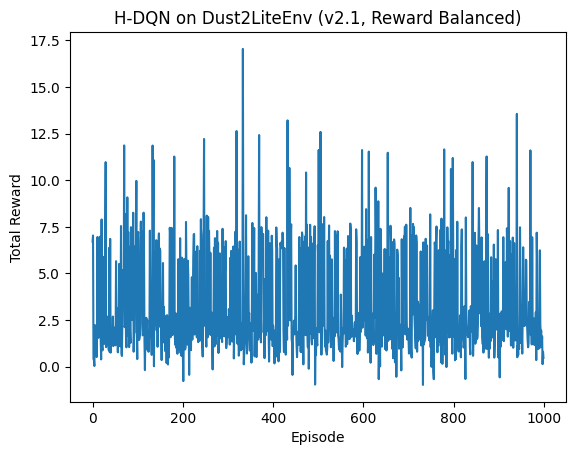

In [75]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from tqdm import trange
import matplotlib.pyplot as plt

# ===============================
# 环境
# ===============================
# 确保你已有 Dust2LiteEnv 定义
env = Dust2LiteEnv()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# ===============================
# 子目标集合
# ===============================
GOALS = ["GO_TO_GOAL", "ENGAGE", "RELOAD"]
n_goals = len(GOALS)

def check_goal_done(goal, env, prev_alive=None, curr_alive=None,
                    prev_ammo=None, curr_ammo=None):
    if goal == "GO_TO_GOAL":
        goal_dist = np.linalg.norm(env.goal_area - env.agent_pos)
        return goal_dist < 8
    elif goal == "ENGAGE":
        return (prev_alive is not None) and (curr_alive is not None) and (curr_alive < prev_alive)
    elif goal == "RELOAD":
        return (prev_ammo is not None) and (curr_ammo is not None) and (prev_ammo < 0.95 and curr_ammo >= 0.95)
    return False


# ===============================
# Q 网络定义
# ===============================
class DQN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, out_dim)
        )
    def forward(self, x):
        return self.net(x)


# ===============================
# 经验回放
# ===============================
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    def push(self, *transition):
        self.buffer.append(transition)
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return map(np.array, zip(*batch))
    def __len__(self):
        return len(self.buffer)


# ===============================
# 初始化
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Q_meta = DQN(state_dim, n_goals).to(device)
Q_meta_target = DQN(state_dim, n_goals).to(device)
Q_low = DQN(state_dim + n_goals, action_dim).to(device)
Q_low_target = DQN(state_dim + n_goals, action_dim).to(device)

Q_meta_target.load_state_dict(Q_meta.state_dict())
Q_low_target.load_state_dict(Q_low.state_dict())

meta_optim = optim.Adam(Q_meta.parameters(), lr=3e-4)
low_optim = optim.Adam(Q_low.parameters(), lr=3e-4)

meta_buffer = ReplayBuffer(50000)
low_buffer = ReplayBuffer(100000)

# ===============================
# 参数
# ===============================
LOW_EPISODE_MAX = 60
BATCH = 128
GAMMA_META = 0.99
GAMMA_LOW = 0.98
TAU = 0.01

EPS_META, EPS_LOW = 1.0, 1.0
EPS_DECAY_META, EPS_DECAY_LOW = 0.995, 0.997
EPS_MIN_META, EPS_MIN_LOW = 0.05, 0.10

META_UPDATE_FREQ = 5
LOW_UPDATE_FREQ = 5
EPISODES = 1000
meta_rewards_log = []
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)


# ===============================
# 主循环
# ===============================
for ep in trange(EPISODES):
    # --- 诊断初始化 ---
    stats = dict(goal_steps=0, hold_steps=0, kills=0, hits_taken=0)
    goal_pick_hist = {g: 0 for g in GOALS}
    s = env.reset()
    done = False
    total_reward = 0.0

    # 强制第一次就触发一次高层决策的初始化变量
    goal_idx, goal_name = None, None
    goal_onehot = np.zeros(n_goals, dtype=np.float32)
    meta_period = 30
    steps_since_meta = meta_period  # 让 t=0 必重选
    goal_completed = False
    meta_start_state = s.copy()
    extrinsic_return = 0.0

    for t in range(1000):
        # ============ 触发高层重选：首次 / 目标完成 / 周期到 ============
        if steps_since_meta >= meta_period or goal_completed or t == 0:
            with torch.no_grad():
                q_meta = Q_meta(torch.tensor(s, dtype=torch.float32, device=device)).cpu().numpy()

            # 构造 mask（不要把所有目标都屏蔽了）
            mask = np.ones_like(q_meta, dtype=bool)
            if env.ammo >= 0.9:
                mask[GOALS.index("RELOAD")] = False
            if np.sum(getattr(env, "enemy_alive", [])) == 0:
                mask[GOALS.index("ENGAGE")] = False
            if not mask.any():
                mask[:] = True  # fallback：避免全 False

            # 采样或贪心
            if random.random() < EPS_META:
                goal_idx = random.randrange(n_goals)
            else:
                goal_idx = np.argmax(np.where(mask, q_meta, -1e9))

            # one-hot 与命名
            goal_onehot = np.zeros(n_goals, dtype=np.float32)
            goal_onehot[goal_idx] = 1.0
            goal_name = GOALS[goal_idx]
            goal_pick_hist[goal_name] += 1     # <<< 关键：在这里统计！

            # 诊断（每 50 集打印一次该集第一次 meta 选择）
            if (ep + 1) % 50 == 0 and t == 0:
                print(f"[MetaPick] goals={GOALS}, mask={mask}, pick={goal_name}, q={q_meta}")

            # 高层段落的累计外奖
            meta_start_state = s.copy()
            extrinsic_return = 0.0
            steps_since_meta = 0
            goal_completed = False  # 重置

        # ============ 低层一步 ============
        sa = np.concatenate([s, goal_onehot]).astype(np.float32)

        with torch.no_grad():
            if random.random() < EPS_LOW:
                a = random.randrange(action_dim)
            else:
                qa = Q_low(torch.tensor(sa, dtype=torch.float32, device=device))
                a = qa.argmax().item()

        # —— 记录“前” —— 
        prev_alive = int(np.sum(getattr(env, "enemy_alive", []))) if hasattr(env, "enemy_alive") else None
        prev_ammo  = float(getattr(env, "ammo", 0.0))
        prev_goal_dist = float(np.linalg.norm(env.goal_area - env.agent_pos)) if hasattr(env, "goal_area") else None
        prev_health = float(getattr(env, "health", 1.0))

        # —— 环境推进 —— 
        s_next, r_ext, done, _ = env.step(a)
        r_ext = np.clip(r_ext, -5, 5)
        total_reward += r_ext
        extrinsic_return += r_ext

        # —— 记录“后” —— 
        curr_alive = int(np.sum(getattr(env, "enemy_alive", []))) if hasattr(env, "enemy_alive") else None
        curr_ammo  = float(getattr(env, "ammo", 0.0))
        curr_goal_dist = float(np.linalg.norm(env.goal_area - env.agent_pos)) if hasattr(env, "goal_area") else None
        curr_health = float(getattr(env, "health", 1.0))

        # === 计算内在奖励（用你现有逻辑） ===
        r_int = 0.0
        if goal_name == "GO_TO_GOAL":
            if (prev_goal_dist is not None) and (curr_goal_dist is not None):
                r_int += 0.4 * (prev_goal_dist - curr_goal_dist)   # 稍增进度奖励
                if curr_goal_dist < 8:
                    r_int += 5.0
        elif goal_name == "ENGAGE":
            if (prev_alive is not None) and (curr_alive is not None) and (curr_alive < prev_alive):
                r_int += 6.0   # from 8.0 -> 6.0
            else:
                try:
                    alive_mask = np.array(env.enemy_alive, dtype=bool)
                    enemies = env.enemies[alive_mask]
                    if len(enemies) > 0:
                        dists = np.linalg.norm(enemies - env.agent_pos, axis=1)
                        nearest_enemy_dist = float(np.min(dists))
                        r_int += 0.05 * (20.0 - nearest_enemy_dist) / 20.0  # from 0.1 -> 0.05
                except Exception:
                    pass
            FIRE_ID = getattr(env, "FIRE_ID", None)
            if FIRE_ID is not None and a == FIRE_ID:
                r_int -= 0.02
        elif goal_name == "RELOAD":
            if (prev_ammo < 0.95) and (curr_ammo >= 0.95):
                r_int += 4.0

        # 目标区小额生存奖励（通用）
        try:
            dist_goal = np.linalg.norm(env.goal_area - env.agent_pos)
            if dist_goal < 8:
                r_int += 0.02
        except Exception:
            pass
        # 健康加成，抑制无脑换血
        r_int += 0.005 * curr_health

        # buffer 写入
        low_buffer.push(sa, a, r_int, np.concatenate([s_next, goal_onehot]).astype(np.float32), done)

        # 目标是否完成（决定是否下次重选）
        goal_completed = check_goal_done(
            goal_name, env,
            prev_alive=prev_alive, curr_alive=curr_alive,
            prev_ammo=prev_ammo, curr_ammo=curr_ammo
        )

        # 若 ENGAGE 失败一次，给高层轻微负奖励（防止卡在“尝试-失败”）
        if (goal_name == "ENGAGE") and (not goal_completed) and (not done):
            extrinsic_return -= 1.0

        # 步进
        s = s_next
        steps_since_meta += 1

        # ======== 低层/高层更新（用你原来的更新块）========
        if len(low_buffer) > BATCH and t % LOW_UPDATE_FREQ == 0:
            s_a, a_b, r_b, s2_a, d_b = low_buffer.sample(BATCH)
            s_a = torch.tensor(s_a, dtype=torch.float32, device=device)
            a_b = torch.tensor(a_b, dtype=torch.long, device=device)
            r_b = torch.tensor(r_b, dtype=torch.float32, device=device)
            s2_a = torch.tensor(s2_a, dtype=torch.float32, device=device)
            d_b = torch.tensor(d_b, dtype=torch.float32, device=device)

            q = Q_low(s_a).gather(1, a_b.unsqueeze(1)).squeeze(1)
            with torch.no_grad():
                a_star = Q_low(s2_a).argmax(1, keepdim=True)
                q_next = Q_low_target(s2_a).gather(1, a_star).squeeze(1)
                q_target = r_b + GAMMA_LOW * q_next * (1 - d_b)
            loss = (q - q_target).pow(2).mean()
            low_optim.zero_grad()
            loss.backward()
            low_optim.step()

            for p, p_t in zip(Q_low.parameters(), Q_low_target.parameters()):
                p_t.data.copy_(TAU * p.data + (1 - TAU) * p_t.data)

        if len(meta_buffer) > BATCH and t % META_UPDATE_FREQ == 0:
            s_m, g, r_m, s2_m, d_m = meta_buffer.sample(BATCH)
            s_m = torch.tensor(s_m, dtype=torch.float32, device=device)
            g = torch.tensor(g, dtype=torch.long, device=device)
            r_m = torch.tensor(r_m, dtype=torch.float32, device=device)
            s2_m = torch.tensor(s2_m, dtype=torch.float32, device=device)
            d_m = torch.tensor(d_m, dtype=torch.float32, device=device)

            q = Q_meta(s_m).gather(1, g.unsqueeze(1)).squeeze(1)
            with torch.no_grad():
                g_star = Q_meta(s2_m).argmax(1, keepdim=True)
                q_next = Q_meta_target(s2_m).gather(1, g_star).squeeze(1)
                q_target = r_m + GAMMA_META * q_next * (1 - d_m)
            loss = (q - q_target).pow(2).mean()
            meta_optim.zero_grad()
            loss.backward()
            meta_optim.step()

            for p, p_t in zip(Q_meta.parameters(), Q_meta_target.parameters()):
                p_t.data.copy_(TAU * p.data + (1 - TAU) * p_t.data)

        # 在“meta阶段终止点”才把高层 transition 写入 meta_buffer
        if goal_completed or steps_since_meta >= meta_period or done:
            meta_buffer.push(meta_start_state, goal_idx, extrinsic_return, s, done)
            meta_start_state = s.copy()
            extrinsic_return = 0.0

        if done:
            break

    # === 探索重置（轻度） ===
    if (ep + 1) % 200 == 0:
        EPS_META = min(1.0, EPS_META + 0.10)
        print(f"[Exploration pulse] EPS_META -> {EPS_META:.2f}")

    meta_rewards_log.append(total_reward)
    if (ep + 1) % 20 == 0:
        avgR = np.mean(meta_rewards_log[-20:])
        print(f"Episode {ep+1}, avg reward = {avgR:.2f}, EPS_META={EPS_META:.2f}, EPS_LOW={EPS_LOW:.2f}")
    if (ep+1) % 20 == 0:
        avgR = np.mean(meta_rewards_log[-20:])
        print(f"Episode {ep+1}, avg reward = {avgR:.2f}, EPS_META={EPS_META:.2f}, EPS_LOW={EPS_LOW:.2f}")
        print(f"[MetaState] Last goal hist = {goal_pick_hist}")
        print(f"[Diag] hold={stats['hold_steps']}, kills={stats['kills']}, hits={stats['hits_taken']}, "
              f"meta={goal_pick_hist}")
        print(Q_meta(torch.zeros(state_dim).to(device)))
# ===============================
# 学习曲线
# ===============================
plt.plot(meta_rewards_log)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("H-DQN on Dust2LiteEnv (v2.1, Reward Balanced)")
plt.show()


In [76]:
# ===============================
# ✅ 策略校正阶段（冻结 Q_meta）
# ===============================
print("\n=== Calibration phase: retraining low-level controller only ===")

for p in Q_meta.parameters():
    p.requires_grad = False  # 冻结高层

CALIBRATION_EPISODES = 200
for ep in trange(CALIBRATION_EPISODES):
    s = env.reset()
    done = False
    total_reward = 0.0

    # 固定高层目标：使用已有 Q_meta 决策
    with torch.no_grad():
        q_meta = Q_meta(torch.tensor(s, dtype=torch.float32, device=device)).cpu().numpy()
    goal_idx = q_meta.argmax()
    goal_onehot = np.zeros(len(GOALS))
    goal_onehot[goal_idx] = 1.0
    goal_name = GOALS[goal_idx]

    for t in range(500):
        sa = np.concatenate([s, goal_onehot])
        with torch.no_grad():
            q_low = Q_low(torch.tensor(sa, dtype=torch.float32, device=device))
            a = q_low.argmax().item() if random.random() > EPS_LOW else random.randrange(action_dim)

        s_next, r_ext, done, _ = env.step(a)
        r_ext = np.clip(r_ext, -3, 3)

        # 内在奖励（和训练阶段相同）
        r_int = 0.0
        if goal_name == "GO_TO_GOAL":
            prev_goal_dist = np.linalg.norm(env.goal_area - env.agent_pos)
            curr_goal_dist = np.linalg.norm(env.goal_area - env.agent_pos)
            r_int += 0.4 * (prev_goal_dist - curr_goal_dist)
            if curr_goal_dist < 8:
                r_int += 5.0

        low_buffer.push(sa, a, r_int, np.concatenate([s_next, goal_onehot]), done)

        # === 仅更新 Q_low ===
        if len(low_buffer) > BATCH:
            s_a, a_b, r_b, s2_a, d_b = low_buffer.sample(BATCH)
            s_a = torch.tensor(s_a, dtype=torch.float32, device=device)
            a_b = torch.tensor(a_b, dtype=torch.long, device=device)
            r_b = torch.tensor(r_b, dtype=torch.float32, device=device)
            s2_a = torch.tensor(s2_a, dtype=torch.float32, device=device)
            d_b = torch.tensor(d_b, dtype=torch.float32, device=device)

            q = Q_low(s_a).gather(1, a_b.unsqueeze(1)).squeeze(1)
            with torch.no_grad():
                q_next = Q_low_target(s2_a).max(1)[0]
                q_target = r_b + GAMMA_LOW * q_next * (1 - d_b)
            loss = (q - q_target).pow(2).mean()
            low_optim.zero_grad()
            loss.backward()
            low_optim.step()

            for p, p_t in zip(Q_low.parameters(), Q_low_target.parameters()):
                p_t.data.copy_(TAU * p.data + (1 - TAU) * p_t.data)

        s = s_next
        total_reward += r_ext
        if done:
            break

    if (ep + 1) % 20 == 0:
        print(f"[Calibration] Episode {ep+1}, total reward = {total_reward:.2f}")

# ===============================
# ✅ 然后再运行评估脚本
# ===============================


=== Calibration phase: retraining low-level controller only ===


  0%|          | 0/200 [00:00<?, ?it/s]



KeyboardInterrupt: 

In [77]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

import numpy as np
import torch
import random
from tqdm import trange

# ===============================
#  1. 基础配置
# ===============================
# 请确保此脚本与你的训练脚本处于同目录，并可访问 Dust2LiteEnv、Q_meta、Q_low
# 若在 Jupyter 运行，只需在训练后直接执行此 cell

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 评估轮数
EVAL_EPISODES = 10
EPS_META_EVAL = 0.01   # 允许极小随机，防止完全确定性塌陷
EPS_LOW_EVAL  = 0.02

# 环境复杂度模式
EVAL_MODES = {
    "static_easy": dict(enemy_move_prob=0.0, shoot_prob=0.0, comment="敌人静止，无攻击"),
    "dynamic_medium": dict(enemy_move_prob=0.3, shoot_prob=0.2, comment="敌人移动，低命中率"),
    "dynamic_hard": dict(enemy_move_prob=0.5, shoot_prob=0.4, comment="敌人移动+射击噪声")
}


# ===============================
#  2. 环境封装
# ===============================
def make_eval_env(mode_config):
    """复制训练环境但调节敌人AI参数"""
    env = Dust2LiteEnv()
    env.enemy_move_prob = mode_config["enemy_move_prob"]
    env.shoot_prob = mode_config["shoot_prob"]
    return env


def patch_enemy_ai_eval(env):
    """为评估版环境绑定可调节敌人AI逻辑"""
    if getattr(env, "_enemy_ai_patched_eval", False):
        return

    orig_step = env.step

    def step_with_ai(a):
        s_next, r_ext, done, info = orig_step(a)
        # --- 敌人逻辑受控于 mode_config ---
        move_p = getattr(env, "enemy_move_prob", 0.0)
        shoot_p = getattr(env, "shoot_prob", 0.0)
        try:
            for i, pos in enumerate(env.enemies):
                if not env.enemy_alive[i]:
                    continue
                # 移动
                if np.random.rand() < move_p:
                    direction = np.random.uniform(-1, 1, 2)
                    direction /= (np.linalg.norm(direction) + 1e-6)
                    step_len = np.random.uniform(0.5, 1.5)
                    env.enemies[i] += direction * step_len
                    env.enemies[i] = np.clip(env.enemies[i], 0, env.map_size)
                # 射击
                if np.random.rand() < shoot_p:
                    dist = np.linalg.norm(env.enemies[i] - env.agent_pos)
                    if dist < 12 and np.random.rand() < shoot_p:
                        env.health -= 0.04
        except Exception:
            pass
        return s_next, r_ext, done, info

    env.step = step_with_ai
    env._enemy_ai_patched_eval = True
    return env


# ===============================
#  3. 评估函数
# ===============================
def evaluate(Q_meta, Q_low, env, episodes=10,
             eps_meta=0.01, eps_low=0.02, n_goals=3, GOALS=None):
    rewards, steps = [], []
    for ep in range(episodes):
        s = env.reset()
        done = False
        total_r = 0.0
        t = 0
        while not done and t < 1000:
            # 高层决策
            with torch.no_grad():
                q_meta = Q_meta(torch.tensor(s, dtype=torch.float32, device=device)).cpu().numpy()
            if random.random() < eps_meta:
                goal_idx = random.randrange(n_goals)
            else:
                goal_idx = q_meta.argmax()
            goal_onehot = np.zeros(n_goals, dtype=np.float32)
            goal_onehot[goal_idx] = 1.0

            # 低层动作
            sa = np.concatenate([s, goal_onehot])
            with torch.no_grad():
                q_low = Q_low(torch.tensor(sa, dtype=torch.float32, device=device)).cpu().numpy()
            if random.random() < eps_low:
                a = random.randrange(env.action_space.n)
            else:
                a = q_low.argmax()

            s, r, done, _ = env.step(a)
            total_r += r
            t += 1
        rewards.append(total_r)
        steps.append(t)
    return np.mean(rewards), np.mean(steps)


# ===============================
#  4. 主评估逻辑
# ===============================
def run_full_evaluation(Q_meta, Q_low, GOALS):
    results = []
    for mode, cfg in EVAL_MODES.items():
        env = make_eval_env(cfg)
        patch_enemy_ai_eval(env)
        mean_r, mean_steps = evaluate(Q_meta, Q_low, env,
                                      episodes=EVAL_EPISODES,
                                      eps_meta=EPS_META_EVAL,
                                      eps_low=EPS_LOW_EVAL,
                                      n_goals=len(GOALS),
                                      GOALS=GOALS)
        results.append((mode, mean_r, mean_steps, cfg["comment"]))
        print(f"[{mode}] mean_reward = {mean_r:.2f}, mean_steps = {mean_steps:.1f}  --> {cfg['comment']}")
    return results


# ===============================
#  5. 执行评估
# ===============================
if __name__ == "__main__":
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)

    print("\n=== Evaluating H-DQN Agent on Dust2LiteEnv ===")
    results = run_full_evaluation(Q_meta, Q_low, GOALS)
    print("\n=== Summary ===")
    for m, r, s, c in results:
        print(f"{m:15s} | Reward: {r:7.2f} | Steps: {s:7.1f} | {c}")




=== Evaluating H-DQN Agent on Dust2LiteEnv ===
[static_easy] mean_reward = -15.17, mean_steps = 101.1  --> 敌人静止，无攻击
[dynamic_medium] mean_reward = -11.89, mean_steps = 98.6  --> 敌人移动，低命中率
[dynamic_hard] mean_reward = -15.98, mean_steps = 95.0  --> 敌人移动+射击噪声

=== Summary ===
static_easy     | Reward:  -15.17 | Steps:   101.1 | 敌人静止，无攻击
dynamic_medium  | Reward:  -11.89 | Steps:    98.6 | 敌人移动，低命中率
dynamic_hard    | Reward:  -15.98 | Steps:    95.0 | 敌人移动+射击噪声
[dynamic_medium] mean_reward = -11.89, mean_steps = 98.6  --> 敌人移动，低命中率
[dynamic_hard] mean_reward = -15.98, mean_steps = 95.0  --> 敌人移动+射击噪声

=== Summary ===
static_easy     | Reward:  -15.17 | Steps:   101.1 | 敌人静止，无攻击
dynamic_medium  | Reward:  -11.89 | Steps:    98.6 | 敌人移动，低命中率
dynamic_hard    | Reward:  -15.98 | Steps:    95.0 | 敌人移动+射击噪声


In [62]:
env = Dust2LiteEnv()
env.enemy_move_prob = 0.0
env.shoot_prob = 0.0
mean_r, mean_steps = evaluate(Q_meta, Q_low, env, episodes=10, eps_meta=0.01, eps_low=0.02)
print("Static baseline:", mean_r)


Static baseline: 1.4556631855761986
